# FrequencySeriesMatrix チュートリアル

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/matrix_frequencyseries.ipynb)

`FrequencySeriesMatrix` は `SeriesMatrix` を周波数領域（FrequencySeries）向けに拡張した 3 次元配列コンテナです（shape: Nrow × Ncol × Nfreq）。

- `df / f0 / frequencies` など FrequencySeries 互換のエイリアス
- 要素アクセスで `FrequencySeries` を返す（`fsm[i, j]`）
- フィルタ適用（magnitude-only: `filter`）と、複素応答の適用（`apply_response`）
- `ifft()` による時間領域 `TimeSeriesMatrix` への変換
- 表示系 (`plot`, `step`, `repr`, `_repr_html_`) をそのまま使用

このノートブックでは追加のユーティリティ関数は定義せず、クラスメソッドを直接呼び出して動作を確認します。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.frequencyseries import FrequencySeries, FrequencySeriesMatrix
from gwexpy.timeseries import TimeSeriesMatrix

plt.rcParams.update({"figure.figsize": (5, 3), "axes.grid": True})

## 代表データを用意
`TimeSeriesMatrix` から `fft/asd` を計算して、`FrequencySeriesMatrix` を得ます。

tsm (2, 2, 1024) sample_rate 256.0 Hz
fft (2, 2, 513) df 0.25 Hz f0 0.0 Hz
asd (2, 2, 129) unit V / Hz(1/2)
frequencies[:5] [0. 1. 2. 3. 4.] Hz


<SeriesMatrix shape=(2, 2, 129) rows=('r0', 'r1') cols=('c0', 'c1')>

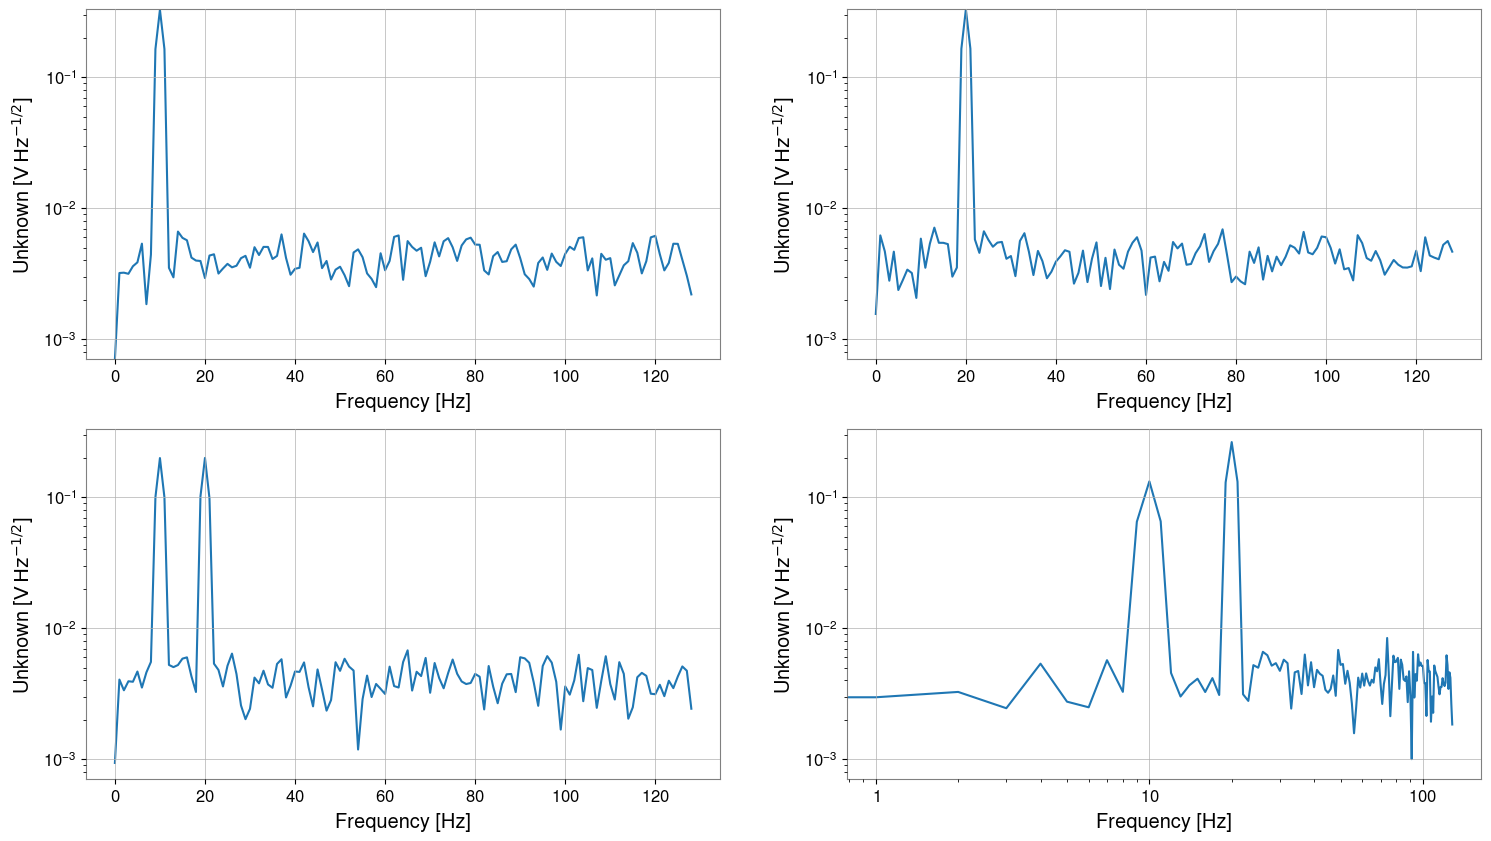

In [2]:
rng = np.random.default_rng(0)

n = 1024
dt = (1 / 256) * u.s
t0 = 0 * u.s
t = (np.arange(n) * dt).to_value(u.s)

tone10 = np.sin(2 * np.pi * 10 * t)
tone20 = np.sin(2 * np.pi * 20 * t + 0.3)

data = np.empty((2, 2, n), dtype=float)
data[0, 0] = 0.5 * tone10 + 0.05 * rng.normal(size=n)
data[0, 1] = 0.5 * tone20 + 0.05 * rng.normal(size=n)
data[1, 0] = 0.3 * tone10 + 0.3 * tone20 + 0.05 * rng.normal(size=n)
data[1, 1] = 0.2 * tone10 - 0.4 * tone20 + 0.05 * rng.normal(size=n)

units = np.full((2, 2), u.V)
names = [["ch00", "ch01"], ["ch10", "ch11"]]
channels = [["X:A", "X:B"], ["Y:A", "Y:B"]]

tsm = TimeSeriesMatrix(
    data,
    dt=dt,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="demo",
)

fft = tsm.fft()
asd = tsm.asd(fftlength=1, overlap=0.5)

print("tsm", tsm.shape, "sample_rate", tsm.sample_rate)
print("fft", fft.shape, "df", fft.df, "f0", fft.f0)
print("asd", asd.shape, "unit", asd[0, 0].unit)
print("frequencies[:5]", asd.frequencies[:5])

display(asd)
asd.plot(subplots=True)
plt.xscale("log")
plt.yscale("log")

## 多様な入力パターン（コンストラクタ例）
`df/f0`、`frequencies`、`FrequencySeries` の 2D リスト、`Quantity` 入力などを確認します。

In [3]:
print("=== FrequencySeriesMatrix コンストラクタ例 ===")

freqs = np.linspace(0, 64, 65) * u.Hz
f = freqs.to_value(u.Hz)

peak10 = np.exp(-0.5 * ((f - 10) / 1.5) ** 2)
peak20 = np.exp(-0.5 * ((f - 20) / 2.0) ** 2)

data_f = np.empty((2, 2, len(freqs)), dtype=float)
data_f[0, 0] = peak10
data_f[0, 1] = peak20
data_f[1, 0] = 0.6 * peak10 + 0.4 * peak20
data_f[1, 1] = 0.2 * peak10 - 0.5 * peak20

units_f = np.full((2, 2), u.V / u.Hz**0.5)
names_f = [["p10", "p20"], ["mix", "diff"]]
channels_f = [["X:A", "X:B"], ["Y:A", "Y:B"]]

# ケース 1: frequencies を明示
fsm = FrequencySeriesMatrix(
    data_f,
    frequencies=freqs,
    units=units_f,
    names=names_f,
    channels=channels_f,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="peaks",
)
print("case1 frequencies", fsm.shape, "df", fsm.df, "f0", fsm.f0)

# ケース 2: df/f0 を指定（Index.define で軸を生成）
fsm_df = FrequencySeriesMatrix(
    data_f, df=1 * u.Hz, f0=0 * u.Hz, units=units_f, names=names_f
)
print("case2 df/f0", fsm_df.shape, "df", fsm_df.df)

# ケース 3: FrequencySeries の 2D リストから構築
fs00 = FrequencySeries(
    data_f[0, 0], frequencies=freqs, unit=units_f[0, 0], name="p10", channel="X:A"
)
fs01 = FrequencySeries(
    data_f[0, 1], frequencies=freqs, unit=units_f[0, 1], name="p20", channel="X:B"
)
fs10 = FrequencySeries(
    data_f[1, 0], frequencies=freqs, unit=units_f[1, 0], name="mix", channel="Y:A"
)
fs11 = FrequencySeries(
    data_f[1, 1], frequencies=freqs, unit=units_f[1, 1], name="diff", channel="Y:B"
)
fsm_from_fs = FrequencySeriesMatrix([[fs00, fs01], [fs10, fs11]])
print(
    "case3 from FrequencySeries",
    fsm_from_fs.shape,
    "cell type",
    type(fsm_from_fs[0, 0]),
)

# ケース 4: Quantity 入力（units を自動設定）
fsm_q = FrequencySeriesMatrix(data_f * (u.mV / u.Hz**0.5), frequencies=freqs)
print("case4 Quantity meta unit", fsm_q.meta[0, 0].unit)

# ケース 5: 不規則 frequencies
irreg = np.array([0, 1, 2, 4, 8]) * u.Hz
fsm_irreg = FrequencySeriesMatrix(
    np.ones((1, 1, len(irreg))), frequencies=irreg, units=[[u.V]], names=[["irreg"]]
)
print("case5 irregular frequencies", fsm_irreg.frequencies)

=== FrequencySeriesMatrix コンストラクタ例 ===
case1 frequencies (2, 2, 65) df 1.0 Hz f0 0.0 Hz
case2 df/f0 (2, 2, 65) df 1.0 Hz
case3 from FrequencySeries (2, 2, 65) cell type <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
case4 Quantity meta unit mV / Hz(1/2)
case5 irregular frequencies [0. 1. 2. 4. 8.] Hz


## 参照・切り出し
- `fsm[i, j]` は `FrequencySeries` を返す
- スライスは `FrequencySeriesMatrix` を返す
- row/col ラベルでもアクセスできる

[0,0] type <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'> df 1.0 Hz f0 0.0 Hz unit V / Hz(1/2)
[0,0] name ch00 channel X:A
[r0,c1] name ch01 channel X:B
asd[:,0] -> <class 'gwexpy.frequencyseries.matrix.FrequencySeriesMatrix'> (2, 1, 129)


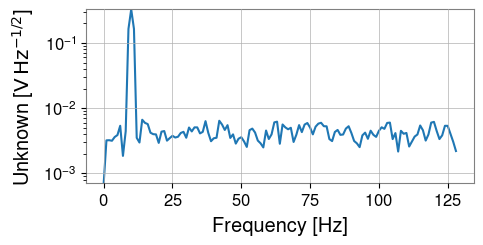

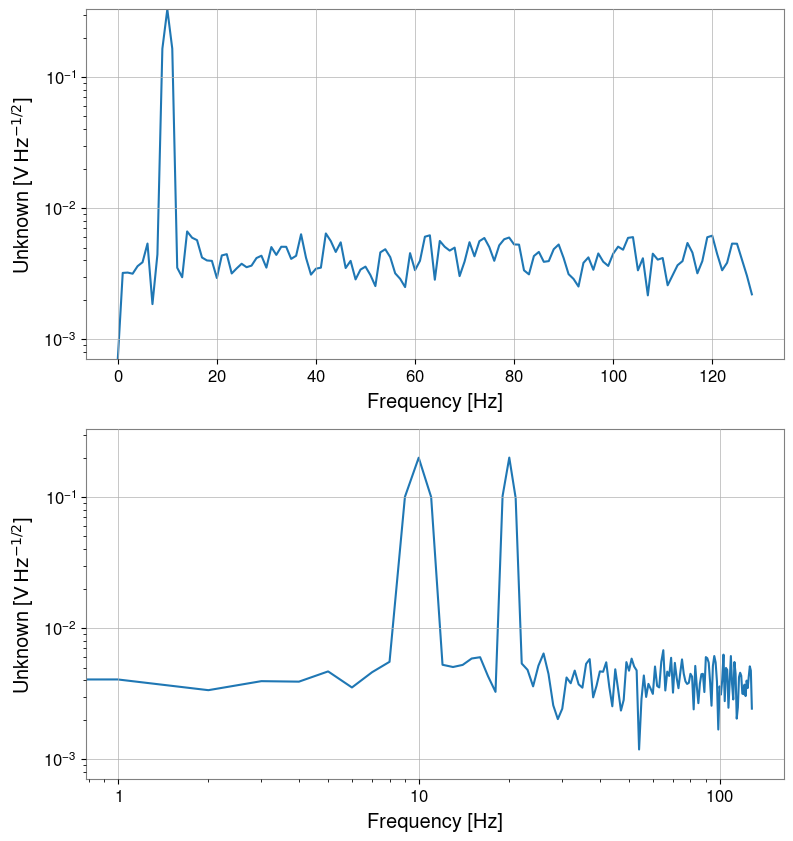

In [4]:
s00 = asd[0, 0]
print("[0,0]", "type", type(s00), "df", s00.df, "f0", s00.f0, "unit", s00.unit)
print("[0,0]", "name", s00.name, "channel", s00.channel)
s00.plot()

s01 = asd["r0", "c1"]
print("[r0,c1]", "name", s01.name, "channel", s01.channel)

sub = asd[:, 0]
print("asd[:,0] ->", type(sub), sub.shape)
sub.plot(subplots=True)
plt.xscale("log")
plt.yscale("log")

## サンプル軸編集（frequency axis）
- `diff` / `pad` は `FrequencySeriesMatrix` を返す


band <class 'gwexpy.frequencyseries.matrix.FrequencySeriesMatrix'> (2, 2, 35) span (<Quantity 5. Hz>, <Quantity 40. Hz>)
diffed <class 'gwexpy.frequencyseries.matrix.FrequencySeriesMatrix'> (2, 2, 34) df 1.0 Hz
padded <class 'gwexpy.frequencyseries.matrix.FrequencySeriesMatrix'> (2, 2, 45) f0 0.0 Hz


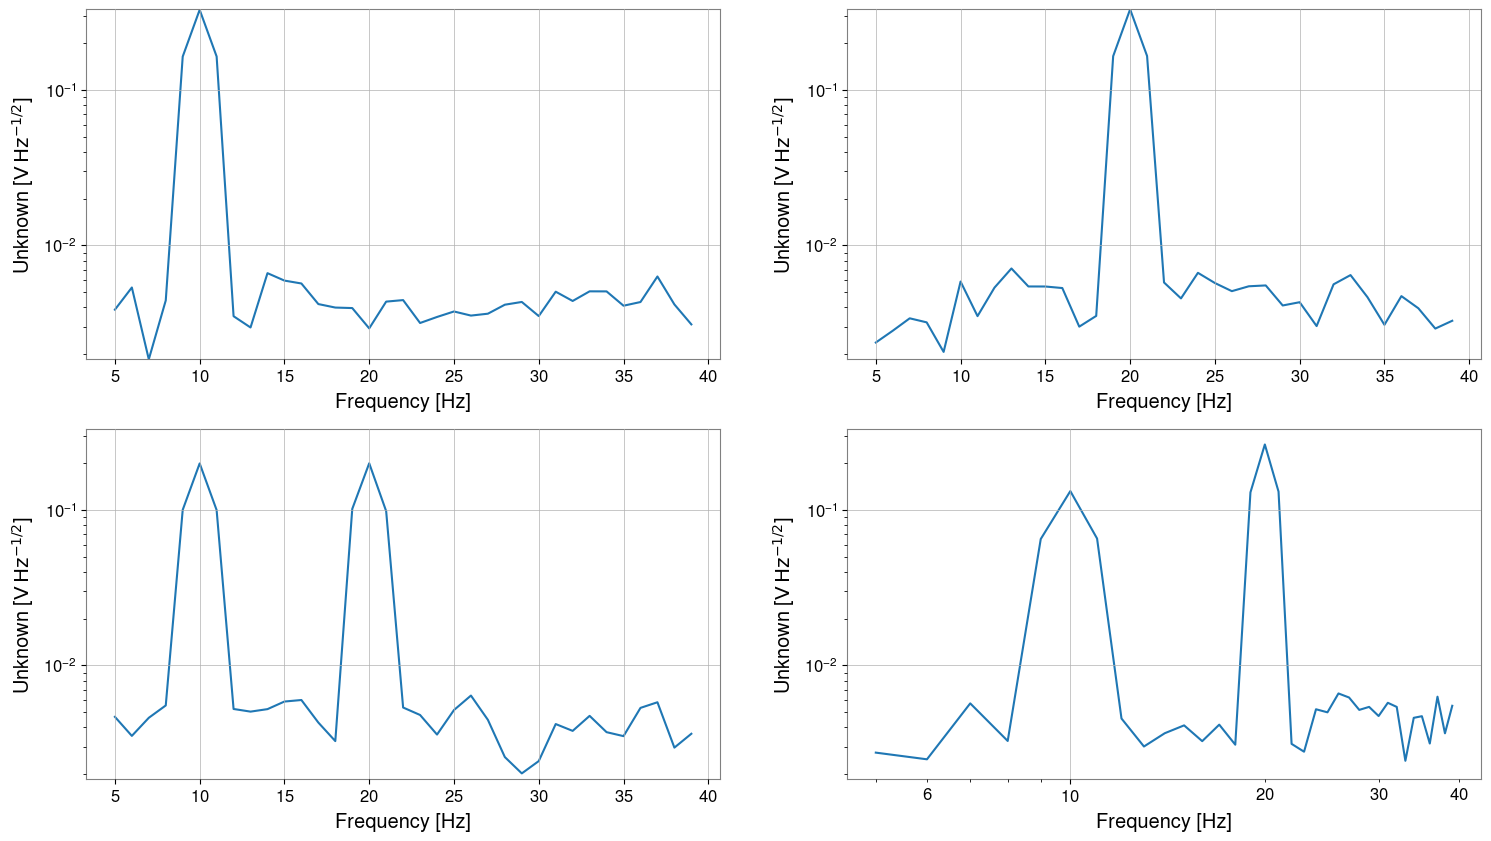

In [5]:
band = asd.crop(start=5 * u.Hz, end=40 * u.Hz)
print("band", type(band), band.shape, "span", band.xspan)
band.plot(subplots=True)
plt.xscale("log")
plt.yscale("log")

diffed = band.diff(n=1)
print("diffed", type(diffed), diffed.shape, "df", diffed.df)

padded = band.pad(5)
print("padded", type(padded), padded.shape, "f0", padded.f0)

## 演算（ufunc / apply_response）
- 係数倍などの ufunc では unit が保たれる
- `apply_response` は複素/実の周波数応答（dimensionless）を掛け合わせる拡張メソッド

scaled unit V / Hz(1/2)
apply_response (2, 2, 35) dtype float64 unit V / Hz(1/2)


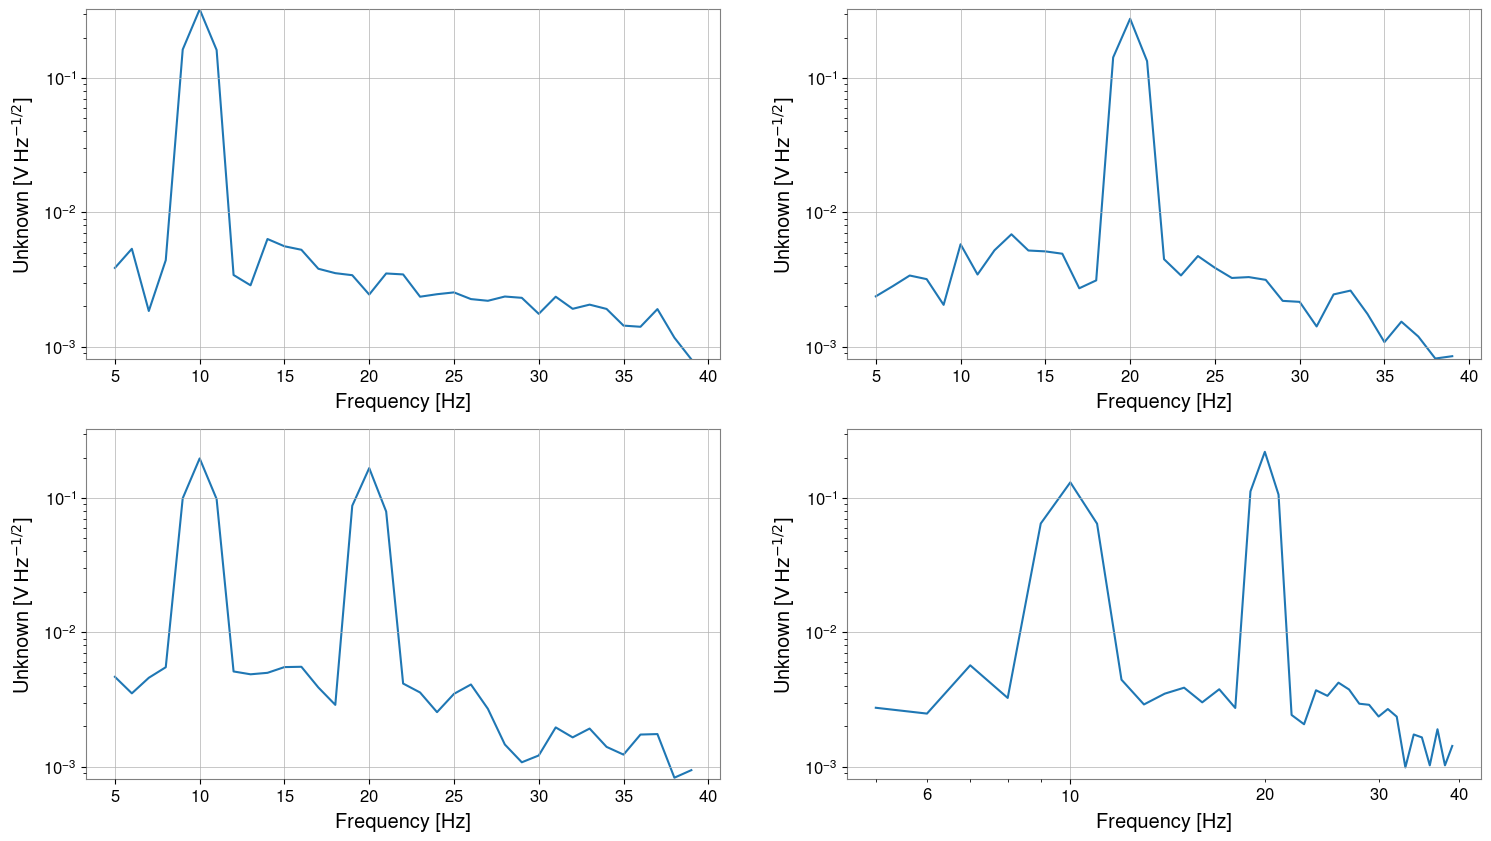

In [6]:
scaled = 2 * band
print("scaled unit", scaled[0, 0].unit)

# 30 Hz あたりから抑える単純な実応答
resp_mag = 1 / (1 + (band.frequencies / (30 * u.Hz)) ** 4)
shaped = band.apply_response(resp_mag)
print(
    "apply_response",
    shaped.shape,
    "dtype",
    shaped.value.dtype,
    "unit",
    shaped[0, 0].unit,
)

shaped.plot(subplots=True)
plt.xscale("log")
plt.yscale("log")

## filter（magnitude-only）
`filter` は GWpy の `fdfilter` に委譲し、フィルタの「振幅応答（magnitude）」を適用します（位相は適用しません）。

ここでは例として、`scipy.signal.butter` で作った IIR フィルタを `fft` に適用してから `ifft()` で時間領域に戻します。

fft_filt (2, 2, 513) df 0.25 Hz
tsm_filt (2, 2, 1024) dt 0.00390625 s


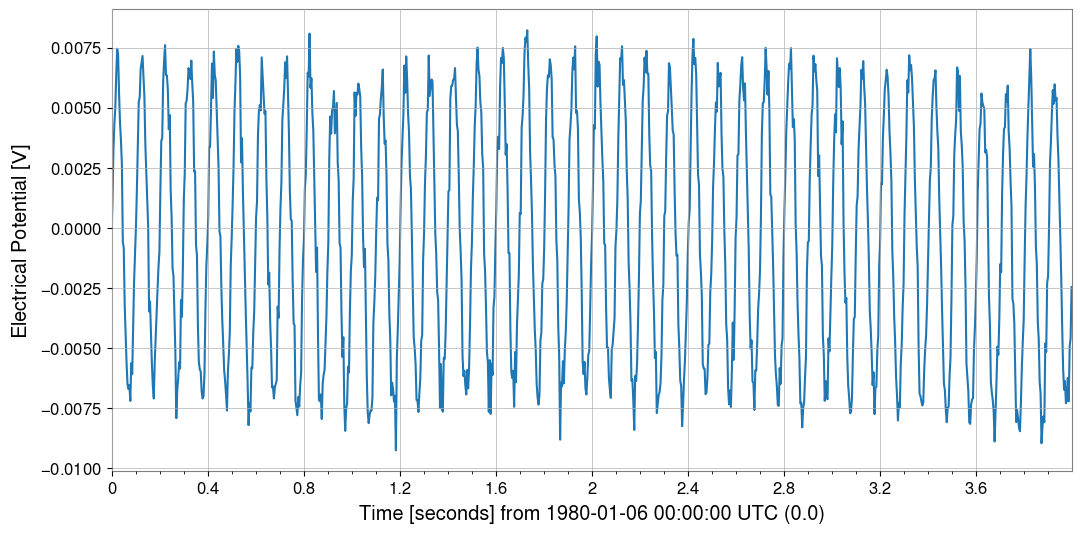

In [7]:
from scipy import signal

sr = tsm.sample_rate.to_value(u.Hz)
b, a = signal.butter(4, [5, 40], btype="bandpass", fs=sr)

fft_filt = fft.filter(b, a, analog=False)
tsm_filt = fft_filt.ifft()

print("fft_filt", fft_filt.shape, "df", fft_filt.df)
print("tsm_filt", tsm_filt.shape, "dt", tsm_filt.dt)

tsm_filt[0, 0].plot(xscale="seconds");

## ifft（FFT から時間領域へ）
`TimeSeriesMatrix.fft()` の出力に対して `ifft()` を適用すると、元の `TimeSeriesMatrix` が再現されます（数値誤差の範囲）。

ifft back (2, 2, 1024) dt 0.00390625 s t0 0.0 s
rms error (cell 0,0) 8.131556499372449e-17


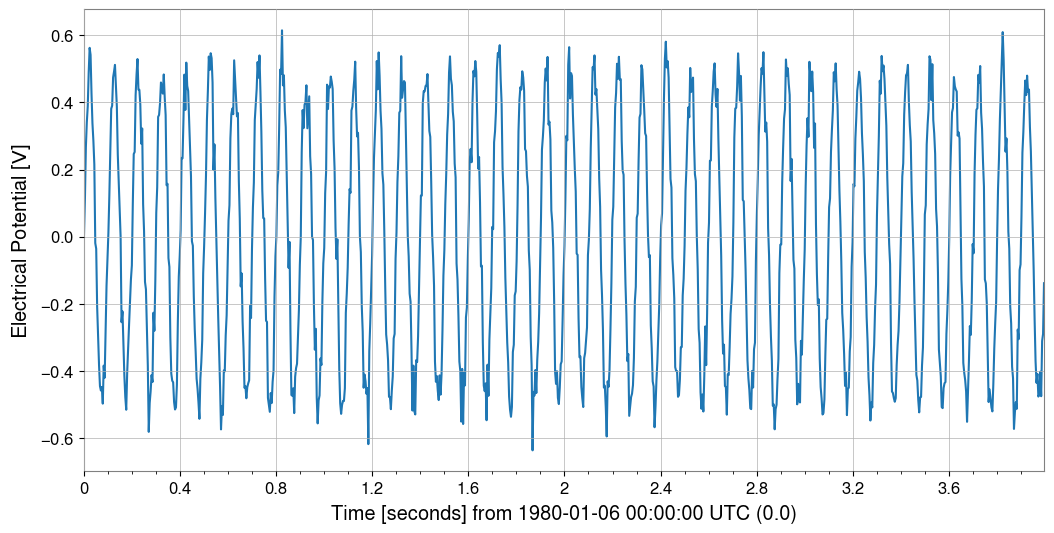

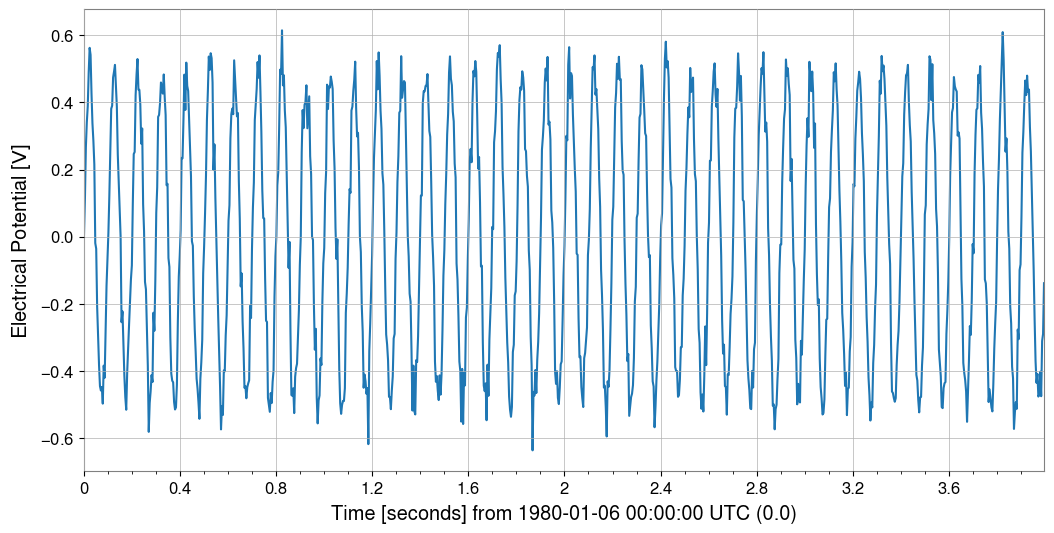

In [8]:
tsm_back = fft.ifft()
rms = np.sqrt(np.mean((tsm_back[0, 0].value - tsm[0, 0].value) ** 2))
print("ifft back", tsm_back.shape, "dt", tsm_back.dt, "t0", tsm_back.t0)
print("rms error (cell 0,0)", rms)

tsm[0, 0].plot(xscale="seconds")
tsm_back[0, 0].plot(xscale="seconds");

## 表示系: repr / plot / step
- `repr`: テキスト表示
- `_repr_html_`: ノートブックでは `display(fsm)` で表形式
- `plot` / `step`: クラスメソッドで直接描画（保存はしない）

repr:
 SeriesMatrix(shape=(2, 2, 35),  name='demo')
  epoch   : 0.0 s
  x0      : 5.0 Hz
  dx      : 1.0 Hz
  xunit   : Hz
  samples : 35

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
          unit  name channel  row  col
0  V / Hz(1/2)  ch00     X:A    0    0
1  V / Hz(1/2)  ch01     X:B    0    1
2  V / Hz(1/2)  ch10     Y:A    1    0
3  V / Hz(1/2)  ch11     Y:B    1    1


<SeriesMatrix shape=(2, 2, 35) rows=('r0', 'r1') cols=('c0', 'c1')>

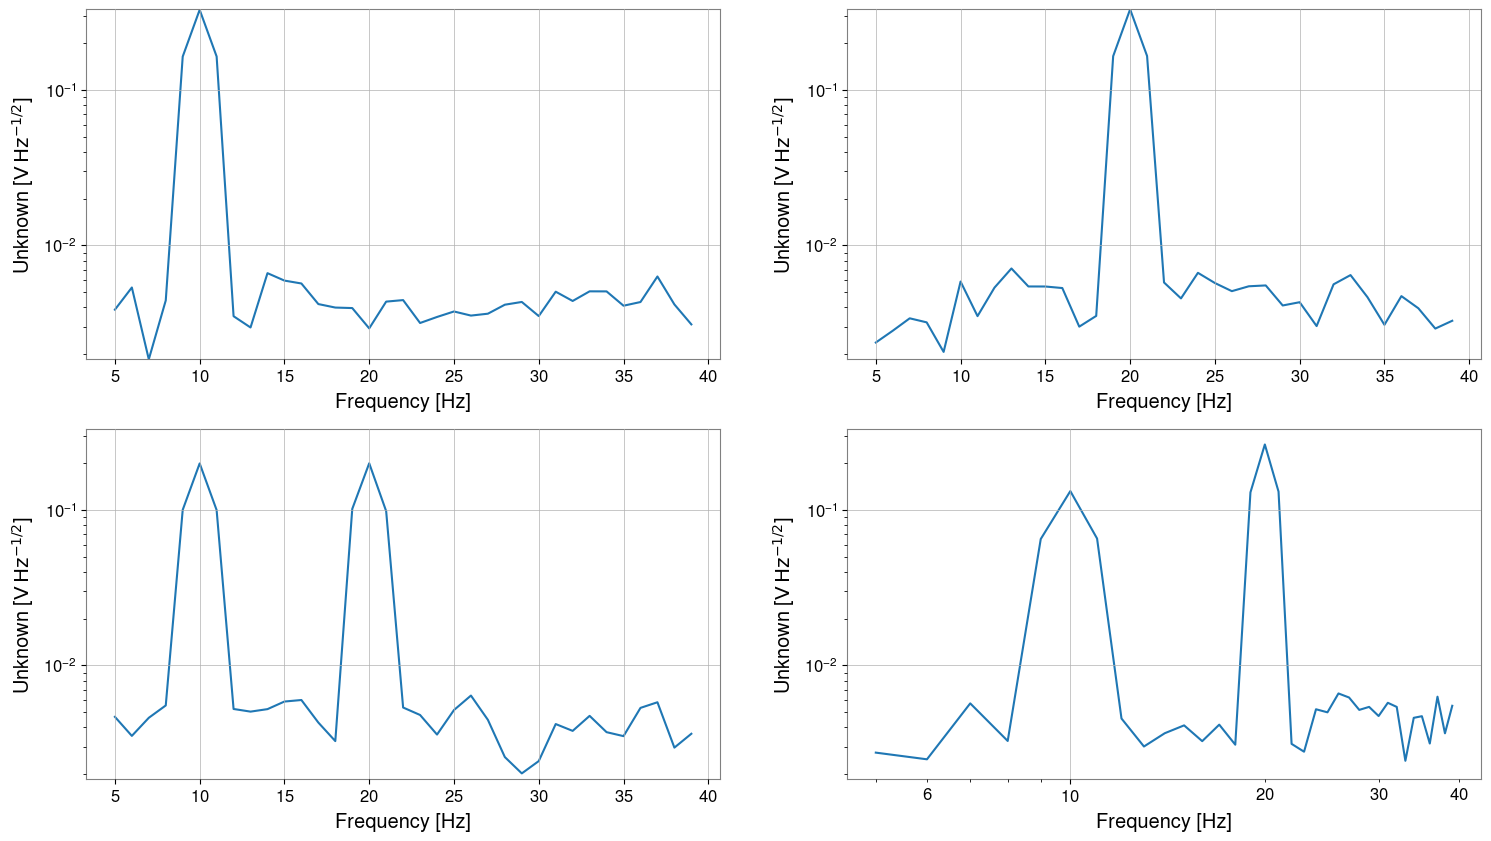

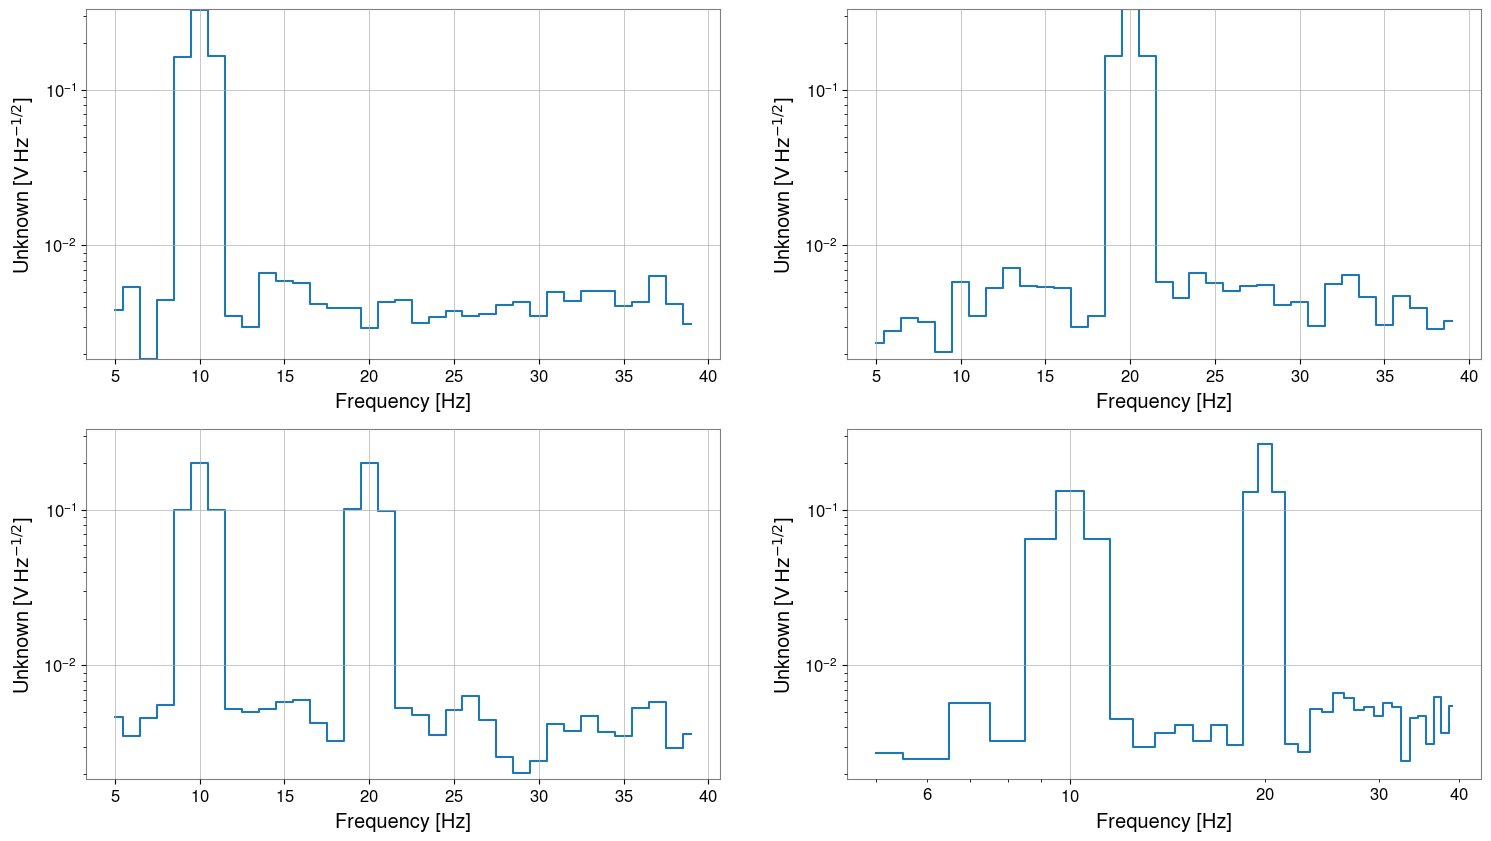

In [9]:
print("repr:\n", band)
display(band)

band.plot(subplots=True)
plt.xscale("log")
plt.yscale("log")

band.step(where="mid")
plt.xscale("log")
plt.yscale("log")

## まとめ
- `FrequencySeriesMatrix` は周波数軸（`df/f0/frequencies`）と要素メタデータを保ったまま、行列として一括処理できる。
- `filter` は magnitude-only のフィルタ適用、`apply_response` は複素応答を含む任意の周波数応答の適用に使える。
- `ifft()` により時間領域 `TimeSeriesMatrix` に戻せるので、周波数領域で処理してから波形として確認する流れが作れる。